# Численное решение уравнения теплопроводности

## 1. Задача

Решается уравнение:
$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} + f(x,t), \quad x \in [0,1], t \in [0,T]
$$

**Исходные данные:**
<!-- - Начальное условие: $u_0(x) = x(x-1)$ -->
- Начальное условие: $u_0(x) = \sin x(x-1)$

<!-- - правая часть: $f(x,t) = e^{-\pi^2 t}(-\pi^2 x(x-1) - 2)$ -->
- правая часть: $f(x,t) =  e^{-\pi^2 t}((x-1)\sin x (1-\pi^2) - 2\cos x)$

<!-- - Точное решение: $u_{exact}(x,t) = e^{-\pi^2 t}x(x-1)$ -->
- Точное решение: $u_{exact}(x,t) = e^{-\pi^2 t}\sin x(x-1)$


**Граничные условия:**
- $u(0,t) = 0$
- $u(1,t) = 0$

**Сетка смеещена слева:** 


$u(0,x_0) =  - u(0,x_1)$


$u(0,x_M) = 0$

## 2. Параметры тестирования

**Общие параметры:**
- Конечное время: $T = 1.0$
- Пространственный шаг: $h = \frac{1}{M - 0.5}$
- Временной шаг: $\tau = \frac{T}{N}$

### Тестовые кейсы

| Кейс | Схема       | M-значения               | Формула для N               | Устойчивость                  |
|------|-------------|--------------------------|-----------------------------|-------------------------------|
| 1    | Неявная     | [10, 20, 40, 80, 160]    | $N = M_i$                    | Безусловная                  |
| 2    | Неявная     | [10, 20, 40, 80, 160]    | $N = 2M_i^2$                 | Безусловная                  |
| 3    | Явная       | [10, 20, 40, 80, 160]    | $N = N_0 \cdot 2^i$        | $\tau \leq h^2/2$  |

## 3. Метрики ошибок

Используется дискретная $L_2$-норма ошибки:
$$
\|u_{num} - u_{exact}\|_{L_2} = \sqrt{h \sum_{j=0}^M (u_{num}(x_j,T) - u_{exact}(x_j,T))^2}
$$

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Запуск C++ программ

In [74]:
!make 
#         N  M  вид схемы
!./proga 2048 32 implicit            # Пример запуска неявной схемы
!./proga 2048 32 explicit            # Пример запуска явной схемы
!./proga convergence implicit 1      # Запуск теста сходимости

g++ -Wall -Wextra -std=c++11 -c main.cpp -o main.o
g++ -Wall -Wextra -std=c++11 -c funcs.cpp -o funcs.o
g++ -Wall -Wextra -std=c++11 -o proga main.o funcs.o
error = 2.89652e-07
error = 1.41395e-07
Convergence results saved to convergence_results.txt
Convergence test (implicit, case 1) completed


### Визуализация решений

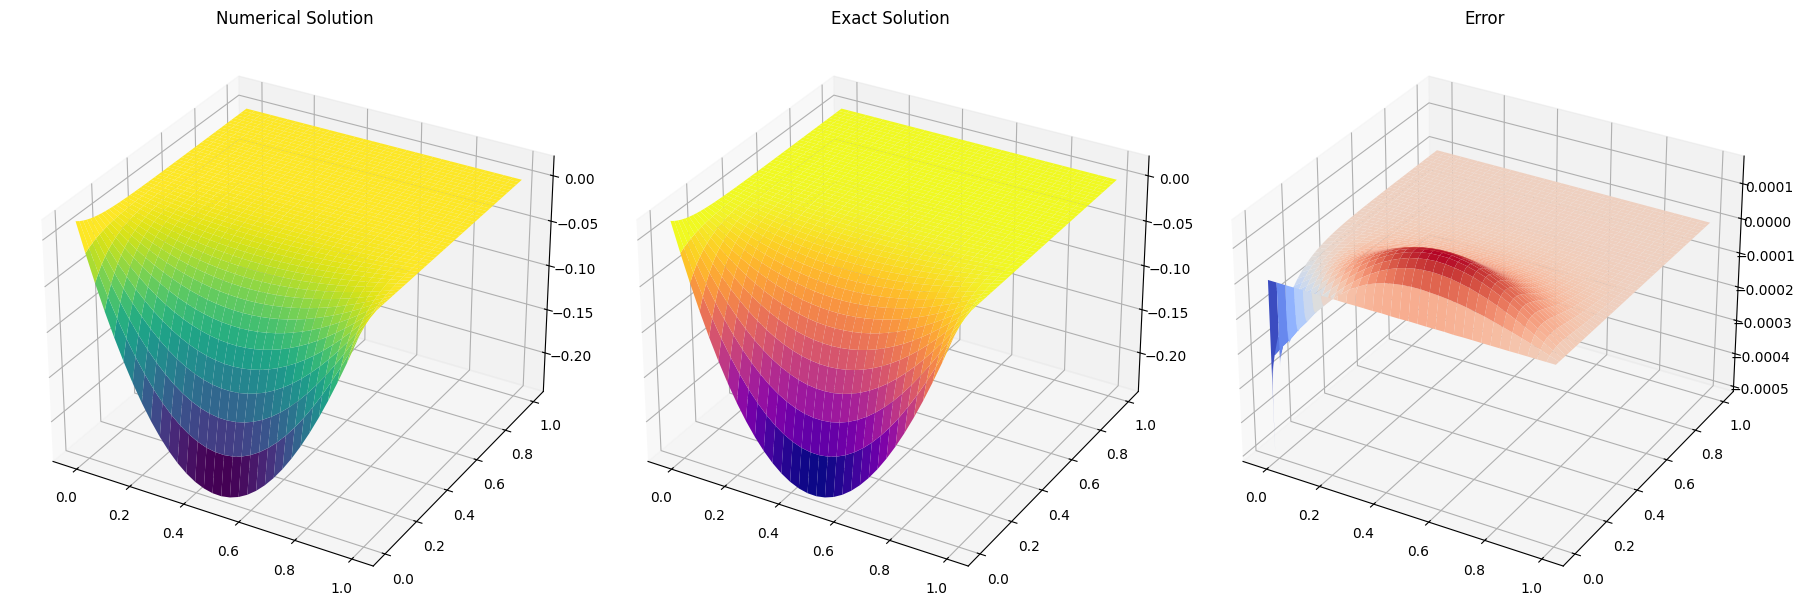

In [75]:
def plot_solutions():
    try:
        x = np.loadtxt('x_grid.txt')
        t = np.loadtxt('t_grid.txt')
        u_num = np.loadtxt('solution_matrix.txt')
        
        X, T = np.meshgrid(x, t)
        # u_exact = np.exp(-np.pi**2 * T) * X * (X - 1)
        u_exact = np.exp(-np.pi**2 * T) * np.sin(X) * (X - 1)

        
        
        fig = plt.figure(figsize=(18, 6))
        
        # Numerical solution
        ax1 = fig.add_subplot(131, projection='3d')
        ax1.plot_surface(X, T, u_num, cmap='viridis')
        ax1.set_title('Numerical Solution')
        
        # Exact solution
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.plot_surface(X, T, u_exact, cmap='plasma')
        ax2.set_title('Exact Solution')
        
        # Error
        ax3 = fig.add_subplot(133, projection='3d')
        error = u_num - u_exact
        ax3.plot_surface(X, T, error, cmap='coolwarm')
        ax3.set_title('Error')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error: {e}")

plot_solutions()

# Анализ порядка сходимости:


### Проверка $O(\tau + h^2)$ для неявной схемы при увеличении M в 2 раза, N в 4 раза:



$$
p = \frac{log(\frac{err2}{err1})}{log(\frac{\tau + h_2^2}{\tau + h_1^2})} \approx \frac{log(\frac{err2}{err1})}{log(\frac{M_2}{M_1})}

$$



In [76]:
!make && ./proga convergence implicit 2

make: Nothing to be done for `all'.
Convergence results saved to convergence_results.txt
Convergence test (implicit, case 2) completed


In [77]:

implicit_data = pd.read_csv("convergence_results.txt", sep='\s+')
# implicit_data.head()

implicit_data['h_ratio'] = implicit_data['h'].shift(1) / implicit_data['h'] 

implicit_data['error_ratio'] = implicit_data['error'].shift(1) / implicit_data['error'] 
implicit_data['log(error_ratio)'] = (np.log(implicit_data['error'].shift(1) / implicit_data['error'])) / \
                                    (np.log(implicit_data['M'] / implicit_data['M'].shift(1))) 

implicit_data

,M,N,h,tau,error,log_h,log_error,h_ratio,error_ratio,log(error_ratio)
0,10,200,0.105263,0.005000,3.396071e-06,-2.251292,-12.59289,NaN,NaN,NaN
1,20,800,0.051282,0.001250,7.596989e-07,-2.970414,-14.09034,2.052632,4.470286,2.160367
2,40,3200,0.025316,0.000313,1.842632e-07,-3.676301,-15.50690,2.025641,4.122901,2.043660
3,80,12800,0.012579,0.000078,4.565163e-08,-4.375757,-16.90223,2.012658,4.036290,2.013030
4,160,51200,0.006270,0.000020,1.137849e-08,-5.072044,-18.29154,2.006290,4.012099,2.004357


### Проверка $O(\tau + h^2)$ для неявной схемы при увеличении M в 2 раза, N = M:



$$
p = \frac{log(\frac{err2}{err1})}{log(\frac{\tau + h_2^2}{\tau + h_1^2})} \approx \frac{log(\frac{err2}{err1})}{log(\frac{M_2}{M_1})}

$$



In [78]:
!make && ./proga convergence implicit 1

make: Nothing to be done for `all'.
Convergence results saved to convergence_results.txt
Convergence test (implicit, case 1) completed


In [79]:

implicit_data = pd.read_csv("convergence_results.txt", sep='\s+')
# implicit_data.head()

implicit_data['h_ratio'] = implicit_data['h'].shift(1) / implicit_data['h'] 

implicit_data['error_ratio'] = implicit_data['error'].shift(1) / implicit_data['error'] 
implicit_data['log(error_ratio)'] = (np.log(implicit_data['error'].shift(1) / implicit_data['error'])) / \
                                    (np.log(implicit_data['M'] / implicit_data['M'].shift(1))) 

implicit_data

,M,N,h,tau,error,log_h,log_error,h_ratio,error_ratio,log(error_ratio)
0,10,10,0.105263,0.10000,0.000181,-2.251292,-8.615699,NaN,NaN,NaN
1,20,20,0.051282,0.05000,0.000049,-2.970414,-9.925453,2.052632,3.705261,1.889575
2,40,40,0.025316,0.02500,0.000017,-3.676301,-10.995340,2.025641,2.915055,1.543523
3,80,80,0.012579,0.01250,0.000007,-4.375757,-11.895730,2.012658,2.460564,1.298989
4,160,160,0.006270,0.00625,0.000003,-5.072044,-12.697000,2.006290,2.228358,1.155981


### Проверка $O(\tau^2 + h^2)$ для явной схемы при увеличении M в 2 раза, N в 2 раза:
***(N подобрано исходя из условной сходимости)***



$$
p = \frac{log(\frac{err2}{err1})}{log(\frac{\tau^2 + h_2^2}{\tau^2 + h_1^2})} \approx \frac{log(\frac{err2}{err1})}{log(\frac{M_2}{M_1})}

$$

In [80]:
! make clean
! make && ./proga convergence explicit 3


rm -f main.o funcs.o proga
g++ -Wall -Wextra -std=c++11 -c main.cpp -o main.o
g++ -Wall -Wextra -std=c++11 -c funcs.cpp -o funcs.o
g++ -Wall -Wextra -std=c++11 -o proga main.o funcs.o
Convergence results saved to convergence_results.txt
Convergence test (explicit, case 3) completed


In [81]:

explicit_data = pd.read_csv("convergence_results.txt", sep='\s+')
# explicit_data.head()

explicit_data['h_ratio'] = explicit_data['h'].shift(1) / explicit_data['h'] 

explicit_data['error_ratio'] = explicit_data['error'].shift(1) / explicit_data['error'] 
explicit_data['log(error_ratio)'] = (np.log(explicit_data['error'].shift(1) / explicit_data['error'])) / \
                                    (np.log(explicit_data['M'] / explicit_data['M'].shift(1))) 
                                    # ((explicit_data['tau'].shift(1) + explicit_data['h'].shift(1) * explicit_data['h'].shift(1))/ (explicit_data['tau'] + explicit_data['h'] * explicit_data['h']) )

explicit_data

,M,N,h,tau,error,log_h,log_error,h_ratio,error_ratio,log(error_ratio)
0,10,51200,0.105263,0.000020,8.186587e-07,-2.251292,-14.01560,NaN,NaN,NaN
1,20,102400,0.051282,0.000010,1.861210e-07,-2.970414,-15.49687,2.052632,4.398529,2.137021
2,40,204800,0.025316,0.000005,4.394130e-08,-3.676301,-16.94041,2.025641,4.235674,2.082591
3,80,409600,0.012579,0.000002,1.028809e-08,-4.375757,-18.39228,2.012658,4.271084,2.094602
4,160,819200,0.006270,0.000001,2.286561e-09,-5.072044,-19.89622,2.006290,4.499373,2.169724


## 6. Визуализация сходимости

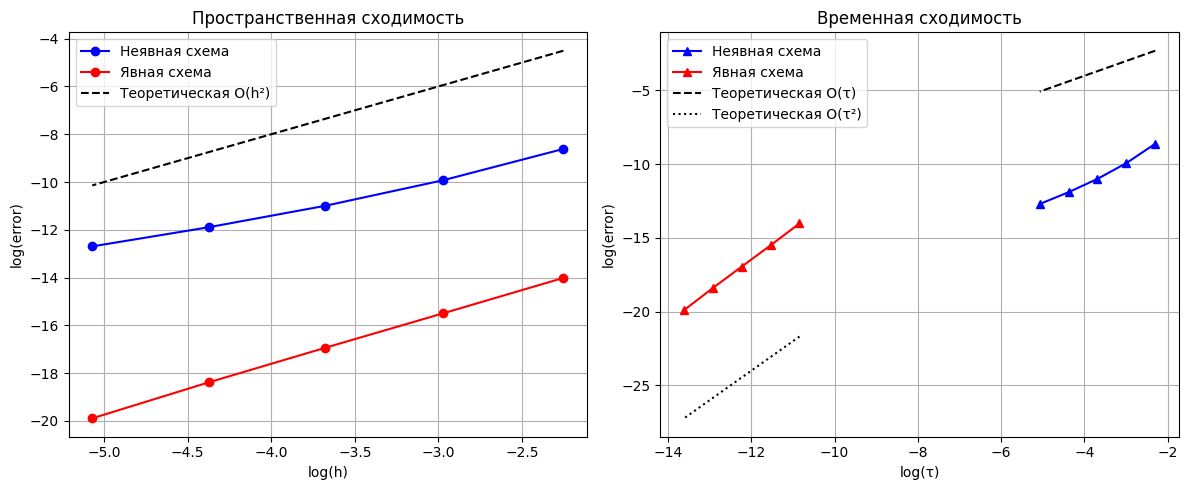

In [82]:

plt.figure(figsize=(12, 5))

# Сходимость по x
plt.subplot(121)
plt.plot(implicit_data['log_h'], implicit_data['log_error'], 'bo-', label='Неявная схема')
plt.plot(explicit_data['log_h'], explicit_data['log_error'], 'ro-', label='Явная схема')
plt.plot(implicit_data['log_h'], 2*implicit_data['log_h'], 'k--', label='Теоретическая O(h²)')
plt.xlabel('log(h)')
plt.ylabel('log(error)')
plt.title('Пространственная сходимость')
plt.legend()
plt.grid(True)

# Сходимость по t
plt.subplot(122)
plt.plot(np.log(implicit_data['tau']), np.log(implicit_data['error']), 'b^-', label='Неявная схема')
plt.plot(np.log(explicit_data['tau']), np.log(explicit_data['error']), 'r^-', label='Явная схема')
plt.plot(np.log(implicit_data['tau']), np.log(implicit_data['tau']),   'k--', label='Теоретическая O(τ)')
plt.plot(np.log(explicit_data['tau']), 2*np.log(explicit_data['tau']), 'k:', label='Теоретическая O(τ²)')
plt.xlabel('log(τ)')
plt.ylabel('log(error)')
plt.title('Временная сходимость')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Выводы

Порядок сходимости действительно равен 2м

In [83]:
!make clean

rm -f main.o funcs.o proga
